In [ ]:
import os
import pandas as pd
import numpy as np
dfs = []
data_path = "../../data/d_us_txt"
for index in ["nyse", "nasdaq", "nysemkt"]:
  for i in os.listdir(f"{data_path}/data/daily/us/{index} stocks/"):
    if i in ["1","2","3","4","5"]:
      for k in os.listdir(f"{data_path}/data/daily/us/{index} stocks/{i}"):
        #symbol	dateOfPrice	open	high	low	close	volume
        dfs.append(pd.read_csv(f"{data_path}/data/daily/us/{index} stocks/{i}/{k}", sep=",", header=0, names = ["symbol","<PER>","dateOfPrice","<TIME>","open","high","low","close","volume","<OPENINT>"]))
    else:
        dfs.append(pd.read_csv(f"{data_path}/data/daily/us/{index} stocks/{i}", sep=",", header=0, names = ["symbol","<PER>","dateOfPrice","<TIME>","open","high","low","close","volume","<OPENINT>"]))

    # except:
    #   print(f"{data_path}/data/daily/us/{index} stocks/{i}")
      # breakIn the SW Development life cycle the actual programming of software code is done during which step

In [ ]:
all_stocks = pd.concat(dfs)
del dfs
all_stocks.columns =  ["symbol","<PER>","dateOfPrice","<TIME>","open","high","low","close","volume","<OPENINT>"]


In [ ]:
import pandas as pd
screener = pd.read_csv("./Stock Market Prediction Graduation Project/stock_info.csv")

In [ ]:
"""
date was in the format of
20190101
day is first 2 digits month is the 2nd 2 digits
"""
import datetime
def to_datetime(x:int):
  day = x%100
  x  = x//100
  month = x%100
  year = x//100
  return datetime.datetime(year,month,day)
all_stocks["dateOfPrice"] = all_stocks["dateOfPrice"].apply(to_datetime)

In [ ]:
analysis_df = all_stocks[(all_stocks["dateOfPrice"] <= datetime.datetime(2013, 11, 26)) & (all_stocks["dateOfPrice"]>= datetime.datetime(2006, 10, 20))].sort_values("dateOfPrice").reset_index(drop=True).copy()
del all_stocks

In [10]:
analysis_df.to_csv("../../data/bloomberg_files/stocks_df.csv")

In [ ]:
import os
from Levenshtein import distance
headlines = []
articles = []
article_date = []
authors = []
links = []
skipped = []
for  k in sorted(os.listdir("./20061020_20131126_bloomberg_news")):
  # if len(articles) > 4000:
  #       break
  for p in os.listdir(f"./20061020_20131126_bloomberg_news/{k}"):
    with open(f"./20061020_20131126_bloomberg_news/{k}/{p}") as f:

      file_contents = f.read()
      if len(file_contents) == 0: continue
      test = file_contents.split("-- ") # file meta data like date, author, headline are split with a "--"
      # print(test[:-1])
      # print(headline)
      try :
        headline = test[1].replace("\n", "")
        author = test[2].replace("\n", "")
        date_line = test[3].replace("\n","").split("-")
      except :
        skipped.append(f"./20061020_20131126_bloomberg_news/{k}/{p}")
        print(k, p, file_contents)
        continue
      link = test[-1].split("\n")[0]
      article = "".join(test[-1].split("\n")[1:])
      # print(headline, author, date_line, link, article)
      # if "To contact the reporter" not in article:
      #   skipped.append(f"./20061020_20131126_bloomberg_news/{k}/{p}")
      #   continue
      # article= article[:article.index("To contact the reporter")]
      headlines.append(headline)
      # date_line = file_contents[2][3:].split("-")
      try :
        article_date.append(datetime.datetime(int(date_line[0]), int(date_line[1]), int(date_line[2][:2]), int(date_line[2][3:5])))
      except :
        date_line = k.split("-")
        article_date.append(datetime.datetime(int(date_line[0]), int(date_line[1]), int(date_line[2][:2])))

      articles.append(article)
      authors.append(author)
      links.append(link)
        # break
  # break





In [ ]:
articles_df = pd.DataFrame({"headline": headlines,
                            "article":articles,
                            "author": authors,
                            "datetime": article_date,
                            "link": links,
                            })

<Axes: >

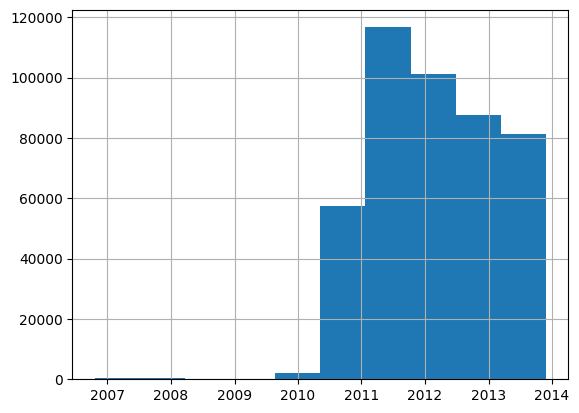

In [ ]:
articles_df = articles_df.sort_values("datetime")
articles_df["datetime"].hist()

In [ ]:
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
model.to("cuda")
model.eval()
nlp = pipeline("ner", model=model, tokenizer=tokenizer, device=torch.device("cuda:0"), batch_size=64)
example = articles_df["article"].tolist()
ner_results = []
with torch.no_grad():
  with torch.autocast(device_type="cuda"):
    for index in tqdm(range(0, len(example), 64)):
      batch_out =[concat_org_names(out) for out in  nlp(example[index:index+64])]
      ner_results.extend(batch_out)

  0%|          | 10/3660 [00:15<1:43:49,  1.71s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3660/3660 [1:36:54<00:00,  1.59s/it]


In [ ]:
# from google.colab import drive
# drive.mount("drive")

Mounted at drive


In [ ]:
import pickle
# with open("../../data/gp_data/ner_results.pkl", 'wb') as  f:
#   pickle.dump(ner_results, f)

with open("../../data/bloomberg_files/ner_results.pkl", 'rb') as  f:
  ner_results = pickle.load(f)

In [ ]:
companies =[]
for k in ner_results:
  companies.extend(k[0])

In [ ]:

def concat_org_names(ner_output):
  """
  ner_output contains the extracted enties from the article
  https://huggingface.co/dslim/bert-base-NER entity types are defined here
  the model might represent one company name by multiple tokens the first one is always of type B-ORG and what follows is I-ORG
  """
  companies = []
  start_end = []
  company = ""
  for i, token in enumerate(ner_output):
    if token["entity"] =="B-ORG":
      if company != "" :
        start_end[-1].append(token["end"])
        companies.append(company.replace(" ##", "").replace("##", ""))
      company = token["word"]
      start_end.append([token["start"]])
    elif token["entity"] == "I-ORG" and company != "":
      company += " "+token["word"]
    else:
      if company != "" :
        start_end[-1].append(token["end"])
        companies.append(company.replace(" ##", "").replace("##", ""))
      company = ""
  if company != "" :
    start_end[-1].append(token["end"])
    companies.append(company.replace(" ##", "").replace("##", ""))
  return companies, start_end


In [ ]:
analysis_df["Ticker"] = analysis_df["symbol"].apply(lambda x: x[:-3] )
screener = screener[screener["Ticker"].isin(analysis_df["Ticker"])].reset_index(drop=True)


In [ ]:
most_companies = pd.Series(companies).value_counts()
highest_k = most_companies[:40000].index # getting the most mentioned 40000 entities as an index to make much faster lookups
final_tickers = []
final_ner_companies = {}
company_final_tickers = []
for company in highest_k: # looping through the companies extracted in a single article
  if company.lower().replace(" ", "") in ["inc", "corp", "co"]: continue
  for i, c in enumerate(screener["Name"].tolist()):
    # this complex if condition just checks if an extracted company by the NER model matches one of the stock screener company names
    if(distance(c.lower().replace("inc", "").replace("corp", "").replace(" ",""), company.replace(" ","").lower().replace("inc", "").replace("corp", "").replace(" ","")) < int(len(c.lower())*0.2) and len(c.lower()) > 4 ) or c.lower().replace("inc", "").replace("corp", "").replace(" ","") == company.lower().replace("inc", "").replace("corp", "").replace(" ",""):
      final_ner_companies[company] = screener["Ticker"][i]
      company_final_tickers.append([c, screener["Ticker"][i]])
      if screener["Ticker"][i] not in final_tickers:
        final_tickers.append(screener["Ticker"][i])


In [ ]:
len(final_tickers)

658

In [ ]:
# screener = screener[screener["Ticker"].isin(final_tickers)].reset_index(drop=True)
analysis_df = analysis_df[analysis_df["Ticker"].isin(final_tickers)].reset_index(drop=True)

In [ ]:
from tqdm import tqdm
article_companies = []
for res in tqdm(ner_results): # looping through the results for all articles
  tickers = []
  company_tickers = []
  for company in res[0]: # looping through the companies extracted in a single article
    if company in final_ner_companies.keys():
      if final_ner_companies[company] not in tickers:
          company_tickers.append([company, final_ner_companies[company]])
          tickers.append(final_ner_companies[company])
          continue
  article_companies.append(company_tickers)
# companies = sorted(companies)

100%|██████████| 447377/447377 [00:01<00:00, 341497.99it/s]


In [ ]:
articles_df["mentioned_companies"] = [[k[0] for k in a ] if len(a) > 0 else a for a in article_companies]
articles_df["mentioned_tickers"] = [[k[1] for k in a ] if len(a) > 0 else a for a in article_companies]

In [ ]:
# articles_df[articles_df["mentioned_tickers"].apply(lambda x : len(x) > 0)]["datetime"].hist() # histogram of relevant articles

In [ ]:
# screener[screener["Ticker"] == "AZN"]

In [ ]:
tickers = []
for a in articles_df[articles_df["mentioned_tickers"].apply(lambda x : len(x) > 0)]["mentioned_tickers"]:
  for k in a:
    tickers.append(k)
pd.Series(tickers).value_counts()[:50]

In [ ]:
# dividing the article into sentences
# every sentence can have multiple companies mentioned in it
#
company_sentences = {"datetime":[], "names":[], "tickers":[], "sentence":[]}
company_interaction = {"datetime":[], "ticker1":[], "ticker2":[]} # mentioned in the same article
for i, r in articles_df[articles_df["mentioned_tickers"].apply(lambda x : len(x) > 0)].reset_index(drop=True).iterrows():
  sentences = r["article"].replace("\n"," ").split(".")
  unique_tickers = list(set(r["mentioned_tickers"]))
  for ticker1 in range(len(unique_tickers)):
    for ticker2 in range(ticker1+1, len(unique_tickers)):
        company_interaction["datetime"].append(r["datetime"])
        company_interaction["ticker1"].append(unique_tickers[ticker1])
        company_interaction["ticker2"].append(unique_tickers[ticker2])

  for sentence in sentences :
    tickers = []
    companies = []
    for ticker, company in zip(r["mentioned_tickers"], r["mentioned_companies"]):
      # if "AAPL" ==ticker:
      #   print(company)
      #   print(sentence)
      if company.lower().replace(".", "").replace("inc", "").replace("corp", "").replace(" ","") in sentence.lower().replace("inc", "").replace("corp", "").replace(" ",""):
        if ticker not in tickers:
          companies.append(company)
          tickers.append(ticker)

    if len(tickers) > 0:
      company_sentences["datetime"].append(r["datetime"])
      company_sentences["sentence"].append(sentence)
      company_sentences["tickers"].append(tickers)
      company_sentences["names"].append(companies)

company_sentences = pd.DataFrame(company_sentences)
company_interaction = pd.DataFrame(company_interaction)

In [ ]:
company_sentences = company_sentences.reset_index(drop=True)


In [6]:
# company_sentences.to_csv("./drive/MyDrive/gp_data/company_sentences.csv")
# company_interaction.to_csv("./drive/MyDrive/gp_data/company_interaction.csv")
import pandas as pd
analysis_df = pd.read_csv("../../data/bloomberg_files/stocks_df.csv")
company_sentences = pd.read_csv("../../data/bloomberg_files/company_sentences.csv")
company_interaction = pd.read_csv("../../data/bloomberg_files/company_interaction.csv")
sub_tickers = list(set(list(company_interaction["ticker1"].unique()) + list(company_interaction["ticker2"].unique())))
company_sentences["tickers"] = company_sentences["tickers"].apply(lambda x: x[1:-1].replace("'","").replace(" ", "").split(","))


In [7]:
# screener = pd.read_csv("/content/Stock Market Prediction Graduation Project/stock_info.csv")
# screener = screener[screener["Ticker"].isin(sub_tickers)]
analysis_df["Ticker"] = analysis_df["symbol"].apply(lambda x: x[:-3])
analysis_df = analysis_df[analysis_df["Ticker"].isin(sub_tickers)]

In [8]:
import numpy as np
#dict of a stock history df for each company
analysis_df = analysis_df.sort_values("dateOfPrice").reset_index(drop=True)
company_stocks = {}
for symbol, data in analysis_df.groupby('Ticker')[analysis_df.columns]: #groupby company
  # checks every close of the day if it's higher that the close in the day before and creates a binary array
  # data["out"] is the target
  # break
  data["target_std"] = np.where(data["close"] - data["close"].shift(1).fillna(0)> 0.04*np.std(data["close"].tolist()[:100]), 1, 0 )
  data["target"] = np.where(data["close"] - data["close"].shift(1).fillna(0)> 0, 1, 0 )
  data.index = pd.to_datetime(data.dateOfPrice) # setting the index as the dateOfPrice for faster look ups when creating target output for each week_graph
  company_stocks[symbol] = data


In [21]:
len(data)

1767

In [9]:
all_targets = []
for k, i in company_stocks.items():
  all_targets.extend(i["target_std"].tolist()[-117:])
pd.Series(all_targets).value_counts()/len(all_targets)

0    0.55452
1    0.44548
Name: count, dtype: float64

In [ ]:
all_targets = []
for k, i in company_stocks.items():
  all_targets.extend(i["target"].tolist())
pd.Series(all_targets).value_counts()/len(all_targets)

1    0.500721
0    0.499279
dtype: float64

In [14]:
from transformers import AutoTokenizer, AutoModel
from typing import List
import torch
from tqdm import tqdm


text =["this is a test"] * 10

def get_article_vectors(text:List[str], batch_size=32, max_length=100, hf_model="sigma")-> torch.Tensor:
  if hf_model == "sigma":
    tokenizer = AutoTokenizer.from_pretrained("Sigma/financial-sentiment-analysis")

    model =  AutoModel.from_pretrained("Sigma/financial-sentiment-analysis")

    model.eval()
    model = model.to("cuda")
  else:
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

    model =  AutoModel.from_pretrained("ProsusAI/finbert")

    model.eval()
    model = model.to("cuda")
  device = next(model.parameters()).device
  all_vectors = []
  with torch.no_grad():
    with torch.autocast(device_type="cuda"): # faster inference
      for i in tqdm(range(0,len(text),batch_size)):
        # tokenizer is used to convert news strings into token_ids
        text_tokens = tokenizer(text[i:i+batch_size],padding=True, truncation= True, max_length=max_length, return_tensors='pt')
        for k,v in text_tokens.items():
          text_tokens[k] = v.to(device)
        out = model(**text_tokens,)
        if hf_model == "sigma":
          vector = out.pooler_output
        else:
          vector = ou.last_hidden_state[:, 0]
        all_vectors.append(vector.cpu().detach())

  all_vectors = torch.cat(all_vectors, axis=0 )
  return all_vectors

In [17]:
company_sentences["datetime"] = pd.to_datetime(company_sentences["datetime"])
company_sentences = company_sentences.sort_values("datetime").reset_index(drop=True)
sentence_vectors = get_article_vectors(company_sentences["sentence"].tolist()) # I thought we didn't need to save the vectors as they only take 4 minutes to produce
torch.save(sentence_vectors, "../../data/bloomberg_files/sentence_vectors_sigma.pt")

In [16]:
import torch
"""
https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
"""
from torch_geometric.data  import InMemoryDataset

class WeekGraphs(InMemoryDataset):
    def __init__(self, root, data_list, transform=None):
        self.data_list = data_list
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        torch.save(self.collate(self.data_list), self.processed_paths[0])
# dataset = WeekGraphs("/content/drive/MyDrive/Stock Market Prediction Graduation Project/graph_dataset_1st_year", week_graphs)

In [ ]:
# edge_types
# article - main_company - company
# article - mentioned - company

from torch_geometric.data import HeteroData
from datetime import timedelta
import numpy as np
from tqdm import tqdm

lag = 21
stock_days = lag - lag// 7 * 2 # saturday and friday for each week

company_sentences["datetime"] = pd.to_datetime(company_sentences["datetime"])
company_interaction["datetime"] = pd.to_datetime(company_interaction["datetime"])
company_to_index = {k :v for v,k in zip(range(len(company_stocks.keys())), company_stocks.keys()) }
index_to_company = {v:k for k,v in company_to_index.items()} #reverse
week_graphs = []
split_index = 0
for day in pd.to_datetime(pd.Series(analysis_df["dateOfPrice"].unique()[lag:])):
  start = day - timedelta(lag)
  print(day,  start)

  target_news = company_sentences[(company_sentences["datetime"]>= start) & (company_sentences["datetime"] < day) ].copy()
  target_interaction = company_interaction[(company_interaction["datetime"]>= start) & (company_interaction["datetime"] < day) ].copy()
  week_graph = HeteroData()
  edges = {}
  # creating edge_index
  edges["sentence-mentioned-company"] = [[],[]]
  edges["company-mentioned_with-company"] = [[],[]]
  edges["company-mentioned_in-sentence"] = [[],[]]

  # creating an array that says stock price info(gone up or down) exists for that day and company or not
  # if info doesn't exist we won't consider the predictions for that day and company
  info_exists = [ day in  company_stocks[index_to_company[i]].index for i in range(len(company_to_index.keys()))]

  y = [ company_stocks[index_to_company[i]].loc[day]["target"] if info_exists[i] else 0  for i in range(len(company_to_index.keys())) ]
  y_std = [ company_stocks[index_to_company[i]].loc[day]["target_std"] if info_exists[i] else 0  for i in range(len(company_to_index.keys())) ]

  company_timeseries =[ company_stocks[index_to_company[i]].loc[start:day-timedelta(1)][["open", "high", "low", "close", "volume"]].to_numpy()  for i in range(len(company_to_index.keys())) ]
  # break
  missing_prices =[ False if x.shape[0] == stock_days else True  for x in company_timeseries  ]
  # break
  company_timeseries =[ x if len(x) == stock_days else np.concatenate([x, np.nan_to_num(x.mean(axis=0).reshape(1,-1), nan=0)+np.zeros((int(stock_days-len(x)), x.shape[1]))])   for x in company_timeseries]
  company_timeseries = np.concatenate([np.expand_dims(x, 0) for x in company_timeseries])
  # # creating gaph edge_index
  for i, (_, r) in enumerate(target_news.iterrows()):
    for comp in r["tickers"]:
      if comp not in company_to_index.keys(): continue
      edges["sentence-mentioned-company"][0].append(i)
      edges["sentence-mentioned-company"][1].append(company_to_index[comp])
      edges["company-mentioned_in-sentence"][1].append(i)
      edges["company-mentioned_in-sentence"][0].append(company_to_index[comp])

  for i, (_, r) in enumerate(target_interaction.iterrows()):
    if r["ticker1"] in company_to_index.keys() and r["ticker2"] in company_to_index.keys():
      edges["company-mentioned_with-company"][0].append(company_to_index[r["ticker1"]])
      edges["company-mentioned_with-company"][1].append(company_to_index[r["ticker2"]])

      edges["company-mentioned_with-company"][1].append(company_to_index[r["ticker1"]])
      edges["company-mentioned_with-company"][0].append(company_to_index[r["ticker2"]])


  for k, v in edges.items():
    edge_name = k.split("-")
    week_graph[edge_name[0],edge_name[1],edge_name[2]].edge_index  = torch.tensor(v)

  week_graph["target"] = torch.as_tensor(y)
  week_graph["target_std"] = torch.as_tensor(y_std)
  week_graph["missing_prices"] = torch.as_tensor(missing_prices)
  week_graph["info_exists"] = torch.as_tensor(info_exists)
  week_graph["company_timeseries"] =torch.from_numpy(company_timeseries)
  week_graph["company"].x = torch.as_tensor(range(len(index_to_company.keys()))) # just the ids to be passed to the embedding layer
  week_graph["sentence"].x =  sentence_vectors[target_news.index]  # get_article_vectors(target_news["content"].to_list()) # Nx768 (number of articles X the embedding dim of finbert)
  week_graph["date"] = day
  week_graphs.append(week_graph)
#   if len(week_graphs) >= 500:
#     WeekGraphs(f"../../data/bloomberg_files/bloomberg_graph_std_trick{split_index}", week_graphs)
#     week_graphs = []
#     split_index +=1
# if len(week_graphs) > 0 :
WeekGraphs("../../data/bloomberg_files/bloomberg_graph_std_trick", week_graphs)


# 25 24 23 22 21 20